In [1]:
import numpy as np
import pandas as pd
import openml
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_selector, ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import os

In [4]:
def get_model_pipeline(model):
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer()),
        ('scale', MinMaxScaler())
    ])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='constant')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore')),
    ])

    col_trans = ColumnTransformer(
        [('num_pipeline', num_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat_pipeline', cat_pipeline, make_column_selector(dtype_include=['object', 'category']))]
    )

    model_pipeline = Pipeline(steps = [
        ('preprocessing', col_trans),
        ('model', model)
    ])
    return model_pipeline

In [5]:
# load datasets from openml
dataset_ids = [1590, 1471, 44, 1461]
X = []
y = []

for did in dataset_ids:
  dataset = openml.datasets.get_dataset(did)
  df, _, _, _ = dataset.get_data(dataset_format="dataframe")
  target_col = dataset.default_target_attribute
  X.append(df.drop(columns=[target_col]))
  y.append(df[target_col])

#### Random Search

In [6]:
from scipy.stats import randint
import pandas as pd

# Parameter distributions - only a few most important parameters: 
param_dist_rs = {
    'model__n_estimators': randint(10, 250),  # num of trees
    'model__max_features': ['sqrt', 'log2', None],  # num of features to consider for best split
    'model__max_depth': randint(3, 20),  # max depth of the trees
    'model__min_samples_leaf': randint(1, 20),  # min samples required at each leaf node
    'model__bootstrap': [True, False]  # if bootstrap samples are used when building trees
}

def run_random_search(X, y, dataset_num):
    rs = RandomizedSearchCV(
        estimator=get_model_pipeline(RandomForestClassifier()),
        cv=3,
        param_distributions=param_dist_rs,
        n_iter=50,
        scoring='roc_auc',
        random_state=123,
        verbose=3
    )
    rs.fit(X, y)

    # print("Best CV score:", rs.best_score_)
    # print("Best params:", rs.best_params_)

    df = pd.DataFrame(rs.cv_results_)
    df["method"] = "random_search"
    df["dataset"] = dataset_num
    df["iter"] = np.arange(1, len(df) + 1)

    return rs, df

In [7]:
# odpalam RS na wszystkich datasetach
results_path = "rf_random_search.pkl"

if not os.path.exists(results_path):
    random_search_fitted = []
    random_search_df = []

    for i in range (4):
        rs, df = run_random_search(X[i], y[i], i)
        random_search_fitted.append(rs)
        random_search_df.append(df)

    # concat all cv_results into a single df
    df_rs_all = pd.concat(random_search_df, ignore_index=True)
    df_rs_all.to_pickle(results_path)
else:
    df_rs_all = pd.read_pickle(results_path)

param_cols = [c for c in df_rs_all.columns if c.startswith("param_")]

mean_scores = (
    df_rs_all
    .groupby(param_cols)["mean_test_score"]
    .mean()
    .reset_index()
)

best_row = mean_scores.loc[mean_scores["mean_test_score"].idxmax()]
best_params = best_row[param_cols].to_dict()
best_score = best_row["mean_test_score"]

print("Best hyperparameters:", best_params)
print("Mean performance across datasets:", best_score)

Best hyperparameters: {'param_model__bootstrap': False, 'param_model__max_depth': 3, 'param_model__max_features': 'log2', 'param_model__min_samples_leaf': 4, 'param_model__n_estimators': 77}
Mean performance across datasets: 0.7385007939817989


In [8]:
# policzymy overall tunability algorytmu random forest: 

# dla kazdego datasetu liczymy roznice miedzy performance modelu z wczesniej wyznaczonymi globalnie optymalnymi hiperparametrami
# a najlepszym auc wyznaczonym dla tego datasetu

# wynik globalnie najlepszej konfiguracji na każdym z datasetów: 
mask = (df_rs_all[param_cols] == pd.Series(best_params)).all(axis=1)
df_global_best = df_rs_all[mask]
global_best_per_dataset = (
    df_global_best
    .groupby("dataset")["mean_test_score"]
    .mean()  # should be one row per dataset anyway
    .reset_index(name="AUC_global_best")
)

# wynik najlepszej konfiguracji dla danego datasetu: 
individual_best_per_dataset = (
    df_rs_all
    .sort_values("mean_test_score", ascending=False)
    .groupby("dataset")
    .first()
    .reset_index()[["dataset", "mean_test_score"]]
    .rename(columns={"mean_test_score": "AUC_individual_best"})
)

# porownanie tych wartosci
comparison_rs = pd.merge(global_best_per_dataset, individual_best_per_dataset, on="dataset")
comparison_rs["AUC_diff"] = comparison_rs["AUC_individual_best"] - comparison_rs["AUC_global_best"]
print(comparison_rs)

# tunability modelu: srednia z tych roznic
model_tunability = comparison_rs["AUC_diff"].mean()
print("Model tunability:", model_tunability)

   dataset  AUC_global_best  AUC_individual_best  AUC_diff
0        0         0.887411             0.917187  0.029776
1        1         0.512048             0.528225  0.016177
2        2         0.957753             0.972869  0.015116
3        3         0.596791             0.625719  0.028928
Model tunability: 0.022499165273136112


In [9]:
# a teraz tunability każdego hiperparametru indywidualnie: 

# wyznaczamy wszystkie przetestowane w rs wartosci dla kazdego hiperparametru
param_values = {p: df_rs_all[p].unique() for p in param_cols}

# funkcja ktora liczy auc dla danego numeru datasetu zestawu hiperparametrow
def evaluate_model(dataset_num, params, cv=3, scoring="roc_auc"):
    model = get_model_pipeline(RandomForestClassifier(**params))
    scores = cross_val_score(model, X[dataset_num], y[dataset_num], cv=cv, scoring=scoring)
    return np.mean(scores)

# jesli jest plik to sciagam z niego wyniki
results_path = "rf_per-hyperparameter-tunability.pkl"

if not os.path.exists(results_path):
    # dla kazdego parametru licze roznice miedzy globalnie najlepszym scorem a tylko tym: 
    results = []
    for p in param_cols:
        print(f"Evaluating tunability of {p} ...")
        values = param_values[p]

        for i in range(4):
            aucs = []

            for val in values:
                params = best_params.copy()
                params[p] = val

                params_for_model = {k.replace("param_model__", ""): v for k, v in params.items()} # cutting the 'param_' prefix
                auc = evaluate_model(i, params_for_model)
                aucs.append(auc)

            # najlepszy AUC jesli zmieniamy tylko p
            best_auc_single = max(aucs)

            # AUC dla globalnie optymalnych hiperparametrow
            auc_global = float(
                global_best_per_dataset.loc[
                    global_best_per_dataset["dataset"] == i,
                    "AUC_global_best"
                ]
            )

            diff = best_auc_single - auc_global
            results.append({"hyperparameter": p, "dataset": i, "AUC_diff": diff})
    # usredniamy wyniki tego wyzej zeby dostac per-hyperparameter tunability
    tune_df = pd.DataFrame(results)
    tune_df.to_pickle(results_path)
else:
    tune_df = pd.read_pickle(results_path)

tune_summary = (
    tune_df.groupby("hyperparameter")["AUC_diff"]
    .agg(["mean", "std", "min", "max"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

print(tune_summary)

                  hyperparameter      mean       std       min       max
4      param_model__n_estimators  0.029113  0.041487  0.002979  0.090456
3  param_model__min_samples_leaf  0.020409  0.022584  0.003340  0.051935
1         param_model__max_depth  0.015912  0.009145  0.003816  0.025844
2      param_model__max_features  0.013881  0.017258  0.001101  0.038927
0         param_model__bootstrap  0.006789  0.008934 -0.001487  0.018709


#### Bayes Search

In [10]:
from skopt import BayesSearchCV
from skopt import space

param_dist_bs = {
    'model__n_estimators': space.Integer(10, 250),  # num of trees
    'model__max_features': ['sqrt', 'log2', None],  # num of features to consider for best split
    'model__max_depth': space.Integer(3, 30),  # max depth of the trees
    'model__min_samples_leaf': space.Integer(1, 20),  # min samples required at each leaf node
    'model__bootstrap': [True, False]  # if bootstrap samples are used when building trees
}

def run_bayes_search(X, y, dataset_num):
    model_pipeline = get_model_pipeline(RandomForestClassifier())
    bayes = BayesSearchCV(
        estimator=model_pipeline,
        search_spaces=param_dist_bs,
        n_iter=50,
        cv=3,
        scoring='roc_auc',
        random_state=42,
        verbose=3
    )
    bayes.fit(X, y)
    df = pd.DataFrame(bayes.cv_results_)
    df["method"] = "bayes"
    df["dataset"] = dataset_num
    return bayes, df

In [11]:
results_path = "rf_bayes_search.pkl"

if not os.path.exists(results_path):
  random_bayes_fitted = []
  random_bayes_df = []

  for i in range(4):    # analogicznie jak w random search
    bayes, df = run_bayes_search(X[i], y[i], i)
    random_bayes_fitted.append(bayes)
    random_bayes_df.append(df)

    df_bayes_all = pd.concat(random_bayes_df, ignore_index=True)
    df_bayes_all.to_pickle(results_path)
else:
  df_bayes_all = pd.read_pickle(results_path)

In [12]:
individual_best_per_dataset_bs = (
    df_bayes_all
    .sort_values("mean_test_score", ascending=False)
    .groupby("dataset")
    .first()
    .reset_index()[["dataset", "mean_test_score"]]
    .rename(columns={"mean_test_score": "AUC_individual_best"})
)

In [13]:
comparison_bs = pd.merge(global_best_per_dataset, individual_best_per_dataset_bs, on="dataset")
comparison_bs["AUC_diff"] = comparison_bs["AUC_individual_best"] - comparison_bs["AUC_global_best"]
print(comparison_bs)

model_tunability = comparison_bs["AUC_diff"].mean()
print("Model tunability BS:", model_tunability)

   dataset  AUC_global_best  AUC_individual_best  AUC_diff
0        0         0.887411             0.917209  0.029798
1        1         0.512048             0.538664  0.026616
2        2         0.957753             0.973686  0.015933
3        3         0.596791             0.658202  0.061411
Model tunability BS: 0.03343942318595561


In [14]:
df_rs = comparison_rs.rename(columns={
    "AUC_individual_best": "AUC_best_rs",
    "AUC_diff": "AUC_diff_rs"
})

df_bs = comparison_bs.rename(columns={
    "AUC_individual_best": "AUC_best_bs",
    "AUC_diff": "AUC_diff_bs"
})

In [15]:
df_merged = pd.merge(df_rs, df_bs, on=["dataset", "AUC_global_best"])
df_merged

,dataset,AUC_global_best,AUC_best_rs,AUC_diff_rs,AUC_best_bs,AUC_diff_bs
0,0,0.887411,0.917187,0.029776,0.917209,0.029798
1,1,0.512048,0.528225,0.016177,0.538664,0.026616
2,2,0.957753,0.972869,0.015116,0.973686,0.015933
3,3,0.596791,0.625719,0.028928,0.658202,0.061411


In [16]:
# tunability modelu: srednia z tych roznic (osobno dla bs i rs)
rs_tunability = df_merged["AUC_diff_rs"].mean()
print("RS model tunability:", rs_tunability)

bs_tunability = df_merged["AUC_diff_bs"].mean()
print("BS model tunability: ", bs_tunability)

RS model tunability: 0.022499165273136112
BS model tunability:  0.03343942318595561


#### Analiza

ile iteracji kazdej metody potrzeba zeby uzyskac stabilne wyniki optymalizacji? 

In [17]:
# dodajemy nr iteracji do df_bayes_all
df_bayes_all = df_bayes_all.copy()
df_bayes_all["iter"] = (
    df_bayes_all.groupby(["dataset", "method"]).cumcount() + 1
)
# df_bayes_all.columns
# df_rs_all.columns
df_hist = pd.concat([df_rs_all, df_bayes_all], ignore_index=True)

def iterations_to_stable_auc(history, patience=20, tol=1e-3):
    auc = history.sort_values("iter")["mean_test_score"].cummax().values
    # czy przez następne "patience" running iteracji running-best wynik wzrośnie o mniej niż "tol"
    for i in range(len(auc) - patience):
        max_future = auc[i + 1:i + 1 + patience].max()
        if (max_future - auc[i]) < tol:
            return i + 1
    return len(auc)

results = [] # wyniki dla każdego zbioru danych i każdej metody
for (dataset, method), history in df_hist.groupby(["dataset", "method"]):
    iters = iterations_to_stable_auc(history) # po ilu teracjach wynik przestał znaczącą się poprawiać
    results.append({"dataset": dataset, "method": method, "iters_to_stable": iters})

results_df = pd.DataFrame(results)
print(results_df)
print("\n\nPodsumowanie stabilności - średnia i mediana:")
print(results_df.groupby("method")["iters_to_stable"].agg(["mean", "median", "min", "max"]))

   dataset         method  iters_to_stable
0        0          bayes                6
1        0  random_search                1
2        1          bayes               28
3        1  random_search                3
4        2          bayes                6
5        2  random_search                5
6        3          bayes               15
7        3  random_search               50


Podsumowanie stabilności - średnia i mediana:
                mean  median  min  max
method                                
bayes          13.75    10.5    6   28
random_search  14.75     4.0    1   50


In [18]:
df_rs_all.groupby('dataset').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__bootstrap,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,method,dataset,iter
0,199.788239,9.391254,0.638241,0.086558,True,16,None,3,230,"{'model__bootstrap': True, 'model__max_depth':...",0.914565,0.914334,0.920987,0.916629,0.003083,3,random_search,0,1
1,4.726478,1.024738,0.358423,0.070048,True,9,log2,11,133,"{'model__bootstrap': True, 'model__max_depth':...",0.906861,0.901339,0.908086,0.905429,0.002935,22,random_search,0,2
2,3.027817,0.326668,0.292693,0.058949,False,4,sqrt,18,136,"{'model__bootstrap': False, 'model__max_depth'...",0.894824,0.887467,0.897837,0.893376,0.004356,42,random_search,0,3
3,22.035462,1.861143,0.578412,0.016709,False,12,sqrt,15,234,"{'model__bootstrap': False, 'model__max_depth'...",0.911213,0.909134,0.914856,0.911734,0.002365,15,random_search,0,4
4,11.108720,0.839855,0.368854,0.030612,False,17,log2,5,106,"{'model__bootstrap': False, 'model__max_depth'...",0.911908,0.909645,0.915217,0.912257,0.002288,13,random_search,0,5
50,17.209290,0.754952,0.121018,0.007403,True,16,None,3,230,"{'model__bootstrap': True, 'model__max_depth':...",0.508196,0.416431,0.466687,0.463771,0.037520,48,random_search,1,1
51,1.847253,0.046088,0.064165,0.004840,True,9,log2,11,133,"{'model__bootstrap': True, 'model__max_depth':...",0.536899,0.428682,0.501201,0.488927,0.045024,28,random_search,1,2
52,1.206557,0.019579,0.046607,0.006138,False,4,sqrt,18,136,"{'model__bootstrap': False, 'model__max_depth'...",0.570058,0.443582,0.541458,0.518366,0.054154,3,random_search,1,3
53,5.347917,0.196689,0.116221,0.007067,False,12,sqrt,15,234,"{'model__bootstrap': False, 'model__max_depth'...",0.533328,0.423226,0.484219,0.480258,0.045036,31,random_search,1,4
54,2.915820,0.039485,0.069790,0.001234,False,17,log2,5,106,"{'model__bootstrap': False, 'model__max_depth'...",0.512046,0.410324,0.454111,0.458827,0.041661,50,random_search,1,5


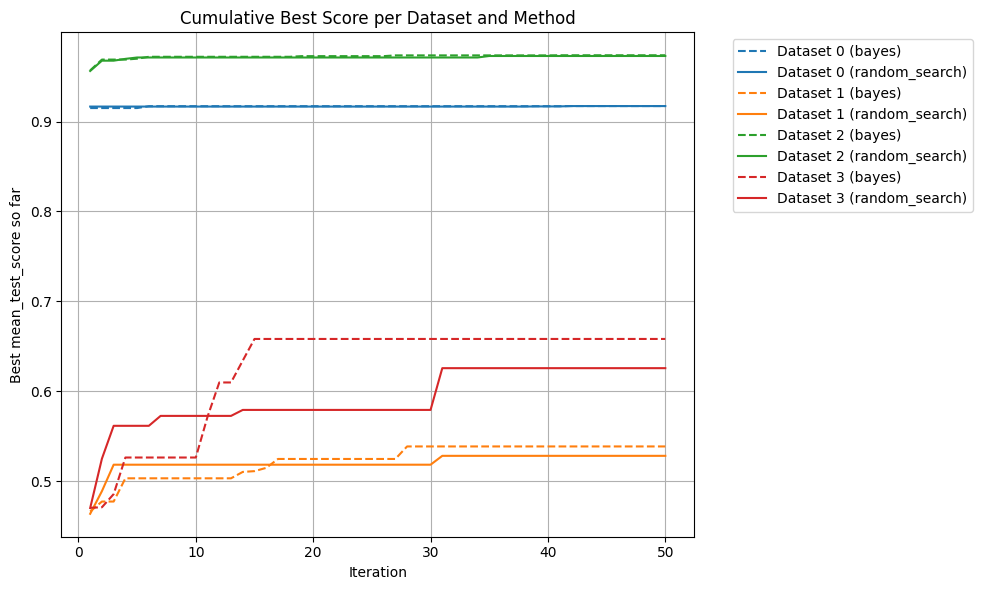

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# sort and compute cumulative max
df_sorted = df_hist.sort_values(['dataset', 'method', 'iter'])
df_sorted['cummax_score'] = (
    df_sorted.groupby(['dataset', 'method'])['mean_test_score'].cummax()
)

# define styles and colors
line_styles = {'random_search': '-', 'bayes': '--'}
datasets = sorted(df_sorted['dataset'].unique())
cmap = plt.get_cmap('tab10')  # or any palette you like
colors = {ds: cmap(i) for i, ds in enumerate(datasets)}

# plot
plt.figure(figsize=(10, 6))

for (dataset, method), group in df_sorted.groupby(['dataset', 'method']):
    plt.plot(
        group['iter'],
        group['cummax_score'],
        color=colors[dataset],
        linestyle=line_styles[method],
        label=f"Dataset {dataset} ({method})"
    )

plt.xlabel('Iteration')
plt.ylabel('Best mean_test_score so far')
plt.title('Cumulative Best Score per Dataset and Method')
plt.grid(True)

# avoid duplicate legend entries for same dataset
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save the plot as JPG
# plt.savefig(os.path.join("plots", "cumulative_best_score_per_dataset_rf.jpg"), dpi=300, bbox_inches='tight')
plt.show()


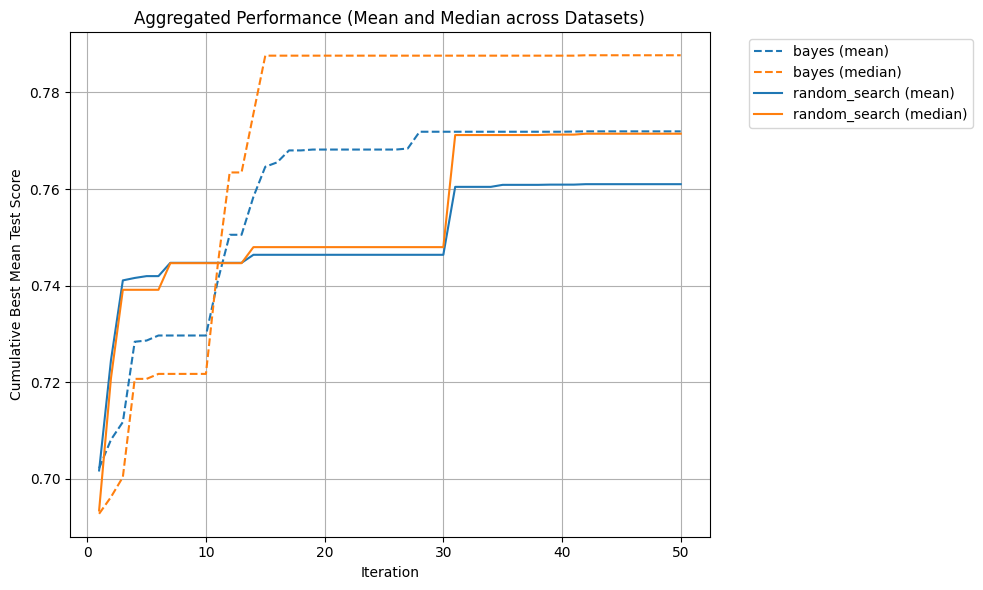

In [ ]:
# srednie i medianowe krzywe running-best - porownanie metod

# calculate aggregated cummax_score between datasets - mean and median
agg_df = (
    df_sorted
    .groupby(['method', 'iter'])['cummax_score']
    .agg(['mean', 'median'])
    .reset_index()
)

# set up chart style
line_styles = {'random_search': '-', 'bayes': '--'}
colors = {'mean': '#1f77b4', 'median': '#ff7f0e'}

# plot
plt.figure(figsize=(10, 6))

for method in agg_df['method'].unique():
    method_data = agg_df[agg_df['method'] == method]

    for stat in ['mean', 'median']:
        plt.plot(
            method_data['iter'],
            method_data[stat],
            linestyle=line_styles[method],
            color=colors[stat],
            label=f"{method} ({stat})"
        )

plt.xlabel('Iteration')
plt.ylabel('Cumulative Best Mean Test Score')
plt.title('Aggregated Performance (Mean and Median across Datasets)')
plt.grid(True)

# remove duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# Save the plot as JPG
# plt.savefig(os.path.join("plots", "aggregated_performance_rf.jpg"), dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print(df_hist)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       199.788239      9.391254         0.638241        0.086558   
1         4.726478      1.024738         0.358423        0.070048   
2         3.027817      0.326668         0.292693        0.058949   
3        22.035462      1.861143         0.578412        0.016709   
4        11.108720      0.839855         0.368854        0.030612   
..             ...           ...              ...             ...   
395       4.607943      0.572854         0.182048        0.072549   
396       4.056700      1.540234         0.315695        0.095069   
397       5.888678      1.139517         0.499040        0.188835   
398       2.052930      0.333953         0.174860        0.016768   
399       1.215846      0.052837         0.086038        0.009874   

     param_model__bootstrap  param_model__max_depth param_model__max_features  \
0                      True                      16                      None   
1        

okreslenie zakresow hiperparametrow dla poszczegolnych modeli

In [22]:
TOP_FRAC = 0.01 # % najlepszych wynikow dla kazdego datasetu

# biore ten top % wynikow dla kazdego datasetu
cutoffs = (
    df_hist.groupby('dataset')['mean_test_score']
    .quantile(1 - TOP_FRAC)
    .rename('cutoff')
)
df_with_cutoff = df_hist.join(cutoffs, on='dataset')
top20 = df_with_cutoff[df_with_cutoff['mean_test_score'] >= df_with_cutoff['cutoff']]

# wybieram taki range kazdego hiperparametru ktory zawiera wszystkie wartosci w tym top %
param_cols = [c for c in df_hist.columns if c.startswith('param_')]

param_ranges = {}
for col in param_cols:
    series = top20[col].dropna()

    # numeric / integer range
    if np.issubdtype(series.dtype, np.integer):
        if not series.empty:
            param_ranges[col] = [int(series.min()), int(series.max())]
        else:
            param_ranges[col] = None

    # non-numeric categorical/string/bool → list of unique values
    else:
        param_ranges[col] = sorted(series.unique().tolist())

print(param_ranges)

{'param_model__bootstrap': [False, True], 'param_model__max_depth': [3, 19], 'param_model__max_features': ['log2', 'sqrt'], 'param_model__min_samples_leaf': [1, 20], 'param_model__n_estimators': [10, 250]}


In [23]:
baseline_auc = df_merged["AUC_global_best"].iloc[0]
baseline_auc
df_merged["AUC_global_best"]

0    0.887411
1    0.512048
2    0.957753
3    0.596791
Name: AUC_global_best, dtype: float64

In [24]:
print("Tunowalność algorytmów")
print(f"Random Search tunability: {comparison_rs['AUC_diff'].mean():.4f}")
print(f"Bayes Search tunability: {comparison_bs['AUC_diff'].mean():.4f}")
print(f"Różnica: {comparison_bs['AUC_diff'].mean() - comparison_rs['AUC_diff'].mean():.4f}")
print()

print("Per dataset:")
print(df_merged[['dataset', 'AUC_diff_rs', 'AUC_diff_bs']])

Tunowalność algorytmów
Random Search tunability: 0.0225
Bayes Search tunability: 0.0334
Różnica: 0.0109

Per dataset:
   dataset  AUC_diff_rs  AUC_diff_bs
0        0     0.029776     0.029798
1        1     0.016177     0.026616
2        2     0.015116     0.015933
3        3     0.028928     0.061411


In [25]:
# różnice dla każdego datasetu i metody
tuning_diffs = []

for (dataset, method), group in df_hist.groupby(['dataset', 'method']):
    best_score = group['mean_test_score'].max()
    for _, row in group.iterrows():
        diff = best_score - row['mean_test_score']
        tuning_diffs.append({
            'dataset': dataset,
            'method': method,
            'iteration': row['iter'],
            'score_diff_from_best': diff
        })
tuning_diffs_df = pd.DataFrame(tuning_diffs)
tuning_diffs_df.head(50)

,dataset,method,iteration,score_diff_from_best
0,0,bayes,1,0.002226
1,0,bayes,2,0.002818
2,0,bayes,3,0.002449
3,0,bayes,4,0.014991
4,0,bayes,5,0.007531
5,0,bayes,6,0.000166
6,0,bayes,7,0.006769
7,0,bayes,8,0.006628
8,0,bayes,9,0.039791
9,0,bayes,10,0.002843


dataset baselines: {0: 0.887410785738305, 1: 0.5120484553499712, 2: 0.9577530788120322, 3: 0.5967908560268872}

Dataset 0
Baseline AUC: 0.8874
Median tunability RS=0.0173, BS=0.0247
Wilcoxon test p-value: 0.0621
No significant difference (p ≥ 0.05)

Dataset 1
Baseline AUC: 0.5120
Median tunability RS=-0.0200, BS=-0.0098
Wilcoxon test p-value: 0.0345
Significant difference (p < 0.05)

Dataset 2
Baseline AUC: 0.9578
Median tunability RS=0.0078, BS=0.0096
Wilcoxon test p-value: 0.6254
No significant difference (p ≥ 0.05)

Dataset 3
Baseline AUC: 0.5968
Median tunability RS=-0.0692, BS=0.0074
Wilcoxon test p-value: 0.0000
Significant difference (p < 0.05)


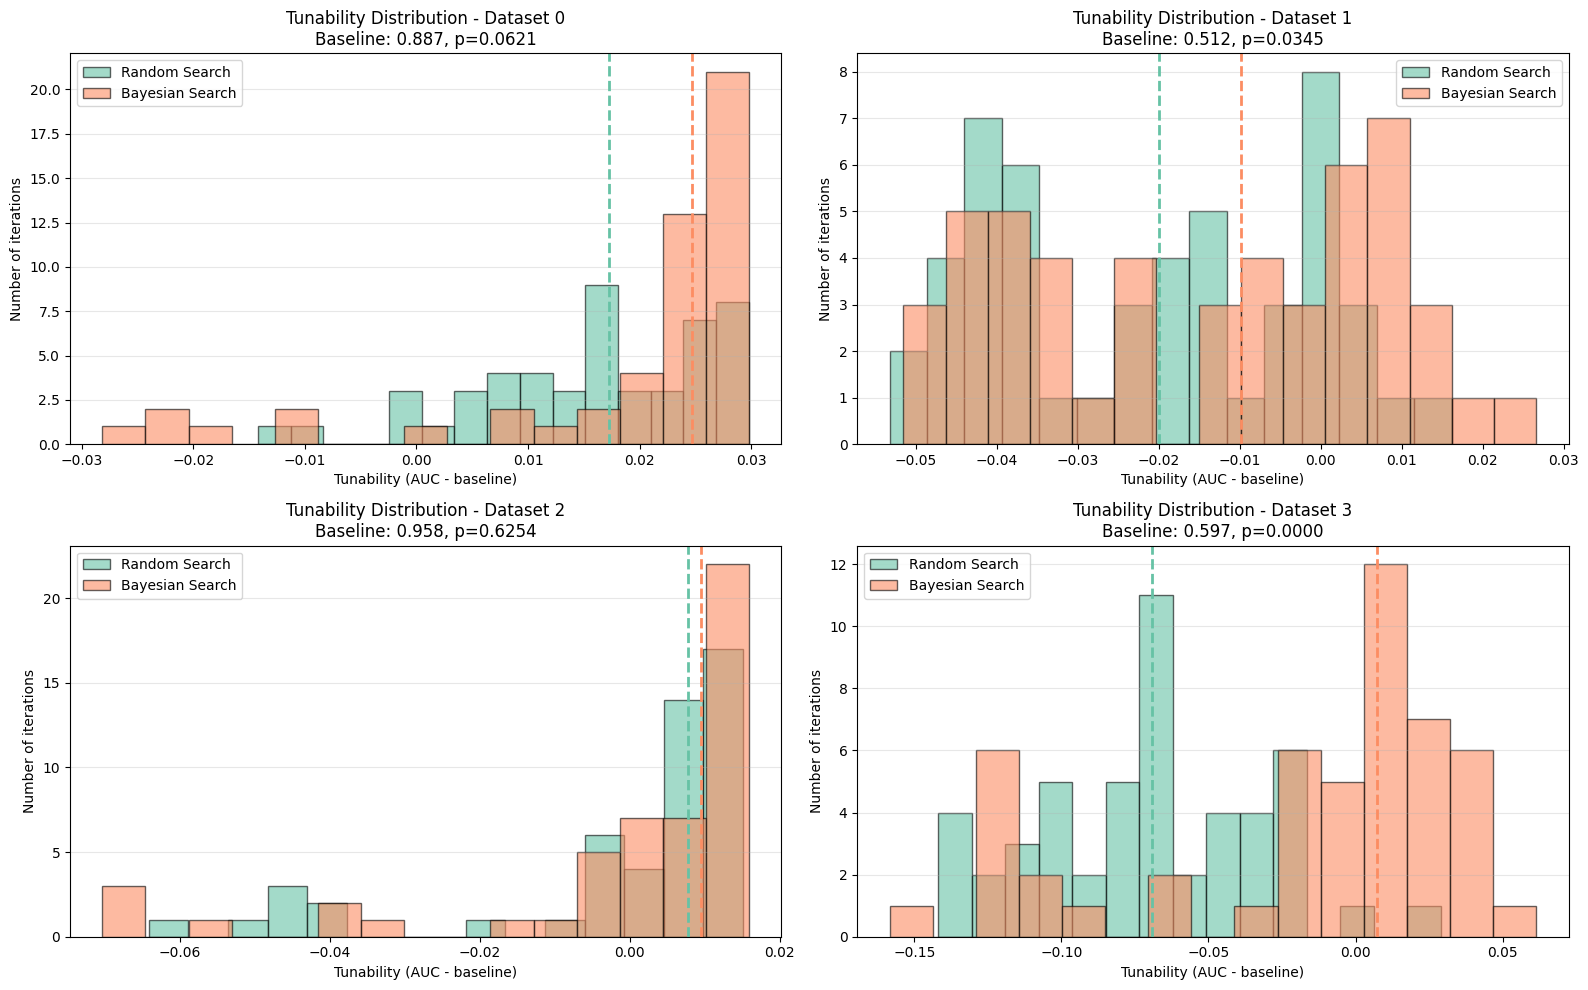

     dataset  baseline_auc  median_rs  median_bs  wilcoxon_p
0  Dataset 0        0.8874     0.0173     0.0247      0.0621
1  Dataset 1        0.5120    -0.0200    -0.0098      0.0345
2  Dataset 2        0.9578     0.0078     0.0096      0.6254
3  Dataset 3        0.5968    -0.0692     0.0074      0.0000


In [ ]:
# tunability per dataset with Wilcoxon test
from scipy.stats import wilcoxon

dataset_baselines = df_merged.set_index('dataset')['AUC_global_best'].to_dict()
print("dataset baselines:", dataset_baselines)

def calculate_tunability_correct(row):
    dataset_id = row['dataset']
    baseline = dataset_baselines[dataset_id]
    return row['mean_test_score'] - baseline

df_hist["tunability"] = df_hist.apply(calculate_tunability_correct, axis=1)

method_colors = {
    "random_search": "#66c2a5",
    "bayes": "#fc8d62" 
}

results = []
dataset_names = ["Dataset " + str(i) for i in range(4)]

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  # Make it easier to iterate through

for i, ds_name in enumerate(dataset_names):
    ds_data = df_hist[df_hist["dataset"] == i]
    
    rs_tunability = ds_data[ds_data["method"] == "random_search"]["tunability"].dropna()
    bs_tunability = ds_data[ds_data["method"] == "bayes"]["tunability"].dropna()
    
    n = min(len(rs_tunability), len(bs_tunability))
    rs_tunability = rs_tunability.iloc[:n]
    bs_tunability = bs_tunability.iloc[:n]

    stat, p = wilcoxon(rs_tunability, bs_tunability)
    results.append({
        "dataset": ds_name,
        "baseline_auc": dataset_baselines[i],
        "median_rs": np.median(rs_tunability),
        "median_bs": np.median(bs_tunability),
        "wilcoxon_p": p
    })
    
    print(f"\n{ds_name}")
    print(f"Baseline AUC: {dataset_baselines[i]:.4f}")
    print(f"Median tunability RS={np.median(rs_tunability):.4f}, BS={np.median(bs_tunability):.4f}")
    print(f"Wilcoxon test p-value: {p:.4f}")
    if not np.isnan(p):
        if p < 0.05:
            print("Significant difference (p < 0.05)")
        else:
            print("No significant difference (p ≥ 0.05)")
    
    # Plot on the corresponding subplot
    ax = axes[i]
    ax.hist(rs_tunability, bins=15, alpha=0.6, label="Random Search",
            color=method_colors["random_search"], edgecolor="black")
    ax.hist(bs_tunability, bins=15, alpha=0.6, label="Bayesian Search",
            color=method_colors["bayes"], edgecolor="black")
    ax.axvline(np.median(rs_tunability), color=method_colors["random_search"], 
               linestyle="--", linewidth=2)
    ax.axvline(np.median(bs_tunability), color=method_colors["bayes"], 
               linestyle="--", linewidth=2)
    
    ax.set_title(f"Tunability Distribution - {ds_name}\nBaseline: {dataset_baselines[i]:.3f}, p={p:.4f}")
    ax.set_xlabel("Tunability (AUC - baseline)")
    ax.set_ylabel("Number of iterations")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()

# plt.savefig(os.path.join("plots", "tunability_distribution_grid_rf.jpg"), dpi=300, bbox_inches='tight')

plt.show()

results_df = pd.DataFrame(results)
print(results_df.round(4))